In [1]:
!pip install torch numpy transformers datasets tiktoken wandb tqdm
!pip install matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
import time
from typing import Optional, Tuple

import tiktoken
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
!git clone https://github.com/chughtapan/nanoGPT

# For colab development
%cd /content/nanoGPT

# For local development
#%cd nanogpt

Cloning into 'nanoGPT'...
remote: Enumerating objects: 691, done.
remote: Total 691 (delta 0), reused 0 (delta 0), pack-reused 691 (from 1)
Receiving objects: 100% (691/691), 955.41 KiB | 2.71 MiB/s, done.
Resolving deltas: 100% (391/391), done.
/content/nanoGPT


In [5]:
from model import *

In [6]:
model_config = "gpt2"
# device = "cpu"
device = "cuda:0" # cpu or cuda:0, cuda:1
device_type = "cuda" if device.startswith("cuda") else "cpu"
temperature = 1.0
top_k = 40

In [8]:
enc = tiktoken.get_encoding("gpt2")
encode = lambda s: enc.encode(s, allowed_special={"<|endoftext|>"})
decode = lambda l: enc.decode(l)

In [9]:
gpt_model = GPT.from_pretrained(model_config)
gpt_model.eval()
gpt_model.to(device)

loading weights from pretrained gpt: gpt2
forcing vocab_size=50257, block_size=1024, bias=True
number of parameters: 123.65M


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

## Step 2: Benchmarking Token Generation



In [10]:
def benchmark_token_generation(generate_fn, max_new_tokens: int, n_iters: int = 10) -> float:
    """
    Benchmark the per-token generation time.
    """
    start_prompt = "\n"
    start_ids = encode(start_prompt)
    x = torch.tensor(start_ids, dtype=torch.long, device=device).view(1, -1)

    if device_type == "cuda":
        torch.cuda.synchronize()

    start_time = time.time()
    for _ in range(n_iters):
        _ = generate_fn(x, max_new_tokens=max_new_tokens, temperature=temperature, top_k=top_k)

    if device_type == "cuda":
        torch.cuda.synchronize()

    elapsed_seconds = time.time() - start_time
    return (elapsed_seconds * 1000) / (n_iters * max_new_tokens)

100%|██████████| 9/9 [09:39<00:00, 64.37s/it] 


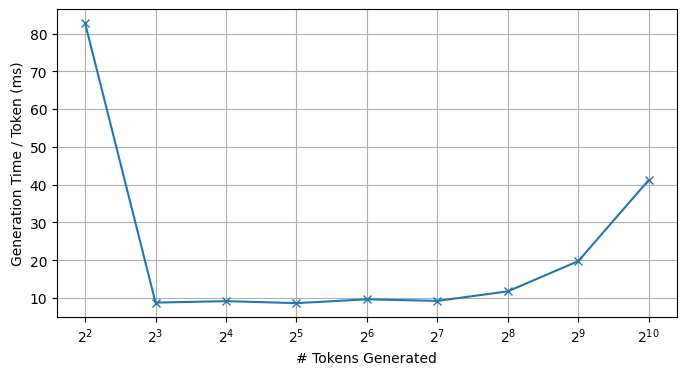

In [11]:
token_counts = [2**i for i in range(2, 11)]
per_token_times_ms = [benchmark_token_generation(gpt_model.generate, tokens) for tokens in tqdm(token_counts)]

plt.figure(figsize=(8, 4))
plt.plot(token_counts, per_token_times_ms, marker='x')
plt.xscale('log', base=2)
plt.xticks(token_counts)
plt.xlabel("# Tokens Generated")
plt.ylabel("Generation Time / Token (ms)")
plt.grid(True)
plt.show()

# Step 3: Implementing and Evaluating KV-caching

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from typing import Optional, Tuple

class SelfAttentionWithCaching(CausalSelfAttention):
    """Extend CausalSelfAttention to support key-value caching."""

    def __init__(self, config):
        super().__init__(config)

    def forward(self, x, prev_k_v: Optional[Tuple[torch.Tensor, torch.Tensor]] = None):
        B, T, C = x.size()  # Batch size, sequence length, embedding dimensionality (n_embd)

        # Calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, hs)

        # Concatenate K,V values from previous steps if available

        ##### Solution Block SA1 #####
        # If prev_k_v is provided, split it into prev_k and prev_v.
        # Concatenate the current k and v tensors with prev_k and prev_v along the time dimension.


        if prev_k_v is not None:
          prev_k, prev_v = prev_k_v

          k = torch.cat((prev_k, k), dim=2)
          v = torch.cat((prev_v, v), dim=2)

        _, _, T_all, _ = k.size()

        ##### End Solution Block SA1 #####



        # Causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T_all) -> (B, nh, T, T_all)
        # Here, `T_all` refers to the total number of tokens seen so far, including both the current
        # sequence and any previous key-value pairs stored in the cache.
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))

        # Original Code: Apply the attention mask to prevent attentions to future tokens.
        # att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))

        ##### Solution Block SA2 #####
        # Apply the correct attention mask to prevent attentions to future tokens
        # Ensure the mask accounts for all tokens processed so far (T_all).
        # Hint: Recall the solution for Q4 (Step 1)

        mask = self.bias[:, :, :T_all, :T_all] == 0
        mask = mask[:, :, -T:, :]
        att = att.masked_fill(mask, float('-inf'))

        ##### End Solution Block SA2 #####

        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)


        y = att @ v  # (B, nh, T, T_all) x (B, nh, T_all, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C)  # Re-assemble all head outputs side by side

        # Output projection
        y = self.resid_dropout(self.c_proj(y))
        return y, (k, v)

In [13]:
class BlockWithCaching(nn.Module):
    """Transformer block with KV caching support."""

    def __init__(self, config, block_id: str):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = SelfAttentionWithCaching(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

        # Assign a unique id for each block
        self.block_id = block_id

    def forward(self, x, k_v_cache: Optional[dict] = None):
        # Original code: Runs attention
        # x = x + self.attn(self.ln_1(x))

        ##### Solution Block B1 #####
        # Step 1: Check if there is a key-value cache for the current block in k_v_cache using self.block_id.
        # Step 2: If a cache exists, retrieve the cached key and value tensors.
        # Step 3: Pass the retrieved key-value pairs to the attention mechanism to avoid recalculating them.
        # Step 4: Update the k_v_cache with the new key-value pairs returned from the attention mechanism.

        prev_k_v = None
        if k_v_cache is not None and self.block_id in k_v_cache.keys():
          prev_k_v = k_v_cache[self.block_id]


        y, kv = self.attn(self.ln_1(x), prev_k_v)
        x = x + y

        if isinstance(k_v_cache, dict):
          k_v_cache[self.block_id] = kv

        ##### End Solution Block B1 #####

        # Run MLP layer on attention outputs
        x = x + self.mlp(self.ln_2(x))
        return x

In [19]:
class GPTWithCaching(GPT):
    """GPT model extended to support KV caching."""

    def __init__(self, config):
        super().__init__(config)
        self.transformer.h = nn.ModuleList([BlockWithCaching(config, f"h{block_id}") for block_id in range(config.n_layer)])

    @torch.no_grad()
    def prefill(self, idx):
        """
        Forward pass through the transformer to initialize the KV cache.

        Args:
            idx (torch.Tensor): Input token indices of shape (batch_size, sequence_length).

        Returns:
            logits (torch.Tensor): The output logits from the model.
            k_v_cache (dict): The key-value cache for each transformer block.
        """
        device = idx.device
        b, t = idx.size()  # Batch size, steps
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device)  # Shape (t)

        # Calculate Embeddings
        tok_emb = self.transformer.wte(idx)  # Token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos)  # Position embeddings of shape (t, n_embd)
        x = tok_emb + pos_emb

        # Run transformer blocks and generate the k_v_cache
        k_v_cache = dict()
        ##### Solution Block G1 #####
        # Iterate over each transformer block in self.transformer.h.
        # For each block, perform a forward pass with the current input x and the k_v_cache.
        # Update x with the output from each block.

        for block in self.transformer.h:
          x = block(x, k_v_cache)

        ##### End Solution Block G1 #####

        x = self.transformer.ln_f(x)
        # Inference-time optimization: only forward the lm_head on the very last position
        logits = self.lm_head(x[:, -1, :])
        return logits, k_v_cache

    @torch.no_grad()
    def generate_token(self, idx, k_v_cache):
        """
        Generate the next token using the current input and the KV cache.

        Args:
            idx (torch.Tensor): Current input token indices of shape (batch_size, 1).
            k_v_cache (dict): The key-value cache for each transformer block.

        Returns:
            logits (torch.Tensor): The output logits for the next token.
        """
        device = idx.device
        # print('idx_size', idx.size())
        _, t = idx.size()

        ##### Solution Block G2 #####
        # Step 1: Extract the last token from idx.
        # Step 2: Compute the position for the last token.
        # Step 3: Calculate the token and position embeddings for the last token.
        # Step 4: Pass the embeddings through each transformer block using the k_v_cache.
        # Step 5: Perform layer normalization and compute the logits for the last position.

        # last_token = idx[:, -1]
        idx = idx[:, -1].unsqueeze(-1)
        # pos = torch.arange(0, t, dtype=torch.long, device=device)  # Shape (t)
        pos = torch.tensor([t-1], dtype=torch.long, device=device)

        # Calculate Embeddings
        tok_emb = self.transformer.wte(idx)  # Token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos)  # Position embeddings of shape (t, n_embd)
        x = tok_emb + pos_emb

        for block in self.transformer.h:
          x = block(x, k_v_cache)

        x = self.transformer.ln_f(x)
        # Inference-time optimization: only forward the lm_head on the very last position
        logits = self.lm_head(x[:, -1, :])
        return logits

        ##### End Solution Block G2 #####

    @torch.no_grad()
    def generate_with_cache(self, idx, max_new_tokens, temperature=1.0, top_k=None, output_check=False):
        """
        Generate new tokens by iteratively predicting the next token and updating the input sequence.

        Args:
            idx (torch.Tensor): Initial input token indices of shape (batch_size, sequence_length).
            max_new_tokens (int): The number of new tokens to generate.
            temperature (float): Scaling factor for the logits to control randomness.
            top_k (int, optional): If specified, restricts the sampling to the top k logits.
            output_check (bool): If True, validates the generated logits against a non-cached forward pass.

        Returns:
            idx (torch.Tensor): The updated input token indices including the newly generated tokens.
        """
        k_v_cache = None
        for ii in range(max_new_tokens):
            if ii == 0:
              logits, k_v_cache = self.prefill(idx)
            else:
              logits = self.generate_token(idx, k_v_cache)

            if output_check:
              _logits, _ = self.forward(idx)

              assert torch.allclose(logits, _logits, atol=1e-3)

            ##### End Solution Block G3 #####

            # Scale logits by the desired temperature
            logits = logits / temperature
            # Optionally limit the logits to the top_k values
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            # Apply softmax to convert logits to probabilities
            probs = F.softmax(logits, dim=-1)
            # Sample from the distribution to get the next token
            idx_next = torch.multinomial(probs, num_samples=1)
            # Append the sampled token to the input sequence
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

# Validation
We will execute the model with both the original and KV-cached generate methods and compare the results.

In [15]:
gpt_model_v2 = GPTWithCaching.from_pretrained(model_config)
gpt_model_v2.eval()
gpt_model_v2.to(device)

start = "Hello world! What's up?\n"
start_ids = encode(start)
x = torch.tensor(start_ids, dtype=torch.long, device=device).view(1, -1)

loading weights from pretrained gpt: gpt2
forcing vocab_size=50257, block_size=1024, bias=True
number of parameters: 123.65M


In [16]:
seed = 1337
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
y = gpt_model_v2.generate_with_cache(x, 100, top_k=top_k, temperature=temperature, output_check=False).tolist()
print(decode(y[0]))

Hello world! What's up?

The moment the door's opened, we were immediately welcomed back into the world of the Dredmor. The Dredmor is now under the control of a new emperor, an entirely new government structure. We've learned that the Dregs would be given command of the whole of their kingdom of Dredmor!

I must say that it is rather nice to actually get to know our new emperor, who's finally taking a lot better with everyone. What more could you ask for


In [17]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
y_old = gpt_model_v2.generate(x, 100, top_k=top_k, temperature=temperature).tolist()
print(decode(y_old[0]))

Hello world! What's up?

The moment the door's opened, we were immediately welcomed back into the world of the Dredmor. The Dredmor is now under the control of a new emperor, an entirely new government structure. We've learned that the Dregs would be given command of the whole of their kingdom of Dredmor!

I must say that it is rather nice to actually get to know our new emperor, who's finally taking a lot better with everyone. What more could you ask for


# Evaluation
Now we will benchmark the new token generation algorithm with KV-caching.

100%|██████████| 9/9 [03:20<00:00, 22.25s/it]


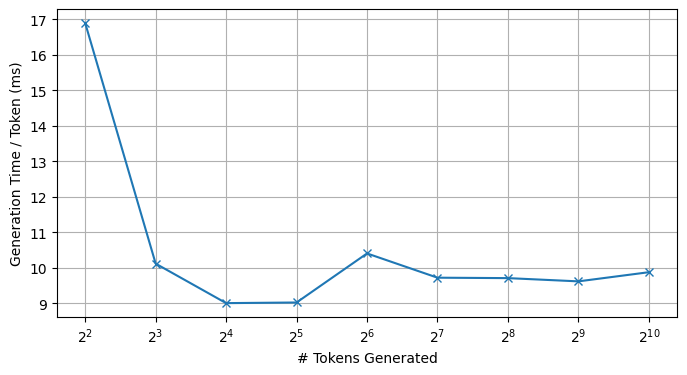

In [18]:
token_counts = [2**i for i in range(2, 11)]
per_token_times_ms = []
for max_new_tokens in tqdm(token_counts):
    per_token_times_ms.append(benchmark_token_generation(gpt_model_v2.generate_with_cache, max_new_tokens))
plt.figure(figsize=(8, 4))
plt.plot(token_counts, per_token_times_ms, marker='x')
plt.xscale('log', base=2)
plt.xticks(token_counts)
plt.xlabel("# Tokens Generated")
plt.ylabel("Generation Time / Token (ms)")
plt.grid(True)
plt.show()

In [20]:
token_counts = [2**i for i in range(2, 11)]
per_token_times_ms_original = [benchmark_token_generation(gpt_model.generate, tokens) for tokens in tqdm(token_counts)]
per_token_times_ms_cached = [benchmark_token_generation(gpt_model_v2.generate_with_cache, tokens) for tokens in tqdm(token_counts)]


100%|██████████| 9/9 [03:18<00:00, 22.01s/it]


In [21]:
improvements = [original / cached for original, cached in zip(per_token_times_ms_original, per_token_times_ms_cached)]
avg_improvement = sum(improvements) / len(improvements)
print(f"Average Improvement in Speed: {avg_improvement}x")


Average Improvement in Speed: 2.021798971642811x
